# Notebook to Evaluate Models

## Setup

In [1]:
# imports
import matplotlib.pyplot as plt
from monai.networks.nets import SwinUNETR
import nibabel as nib
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score
from tqdm import tqdm
import umap

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [ ]:
# get device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# set random seeds for reproducibility
random.seed(100)
np.random.seed(100)
torch.manual_seed(100)


Using device: cuda


In [3]:
# pretrained checkpoints and data root
ckpt_img_clip = "/ministorage/adina/pretrain_sweep/checkpoints/dea46vee/all_datasets_clip_pretrained-epochepoch=715-valval_loss=0.0222-stepstep=41528.ckpt"
ckpt_img_only = "/ministorage/adina/pretrain_sweep_no_clip/checkpoints/ijj3zh4v/all_datasets_pretrained_no_clip-epochepoch=181-valval_loss=0.0241-stepstep=10556.ckpt"
ckpt_img_clip_rewrites = "/ministorage/adina/pretrain_sweep_rewrites/checkpoints/7w1g9wdt/all_datasets_clip_pretrained-rewrites-epochepoch=042-valval_loss=0.4118-stepstep=2494.ckpt"
data_root = "/midtier/paetzollab/scratch/ads4015/data_selma3d/selma3d_finetune_patches"


In [4]:
# define model specs
model_specs = {
    'Image+CLIP': {'path': ckpt_img_clip, 'feature_size': 12, 'embed_dim': 512},
    'Image-only': {'path': ckpt_img_only, 'feature_size': 48, 'embed_dim': 256},
    'Image+CLIP-rewrites': {'path': ckpt_img_clip_rewrites, 'feature_size': 12, 'embed_dim': 128},
    'Random': {'path': None, 'feature_size': 12, 'embed_dim': 512}
}


In [5]:
# define color palette for each model (train, val)
model_colors = {
    'Image+CLIP': ('#1f77b4', '#aec7e8'), # blues
    'Image-only': ('#ff7f0e', '#ffbb78'), # oranges
    'Image+CLIP-rewrites': ('#2ca02c', '#98df8a'), # greens
    'Random': ('#d62728', '#ff9896') # reds
}


## Helper Functions

In [6]:
# function to load fraction of patches from each class
def load_fraction_patches(base_dir, fraction=0.5):

    # ensure fraction is between 0 and 1
    assert 0 < fraction <= 1, "Fraction must be between 0 and 1"

    # initialize lists to hold data and labels
    samples, labels = [], []

    # get class directories
    class_dirs = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])

    # iterate over each class directory
    for class_dir in class_dirs:

        # get images in class directory
        folder = os.path.join(base_dir, class_dir)
        images = [f for f in os.listdir(folder) if (f.endswith('.nii.gz') or f.endswith('.nii')) and '_label' not in f and 'preds' not in f]

        # ensure images are found
        if not images:
            print(f"No images found in {folder}. Skipping this class.")
            continue
    
        # shuffle and keep fraction of images
        random.shuffle(images)
        num_to_keep = max(2, int(len(images) * fraction))  # ensure at least two images are kept
        images = images[:num_to_keep]

        # load images and corresponding labels
        for i in images:
            path = os.path.join(folder, i)
            img = nib.load(path).get_fdata()
            img = (img - img.min()) / (img.max() - img.min() + 1e-8)  # normalize to [0, 1]
            samples.append(img[None, None]) # [1, D, H, W]
            labels.append(class_dir)

        # print progress
        print(f'{class_dir}: kept {num_to_keep}/{len(images)} images ({fraction*100:.1f}%)')

    # print total samples loaded
    total = len(samples)
    print(f'\nLoaded {total} total patches across {len(class_dirs)} classes ({fraction*100:.1f}% per class).')

    # return array of samples and labels and classes
    return np.array(samples), np.array(labels), class_dirs


In [7]:
# function to load backbone model
def load_backbone_custom(cfg):

    # get model path and specs
    model_path, model_feats = cfg['path'], cfg['feature_size']
    if model_path is None:
        print(f'Initializing random SwinUNETR (feature size={model_feats})')
        model = SwinUNETR(img_size=(96, 96, 96), in_channels=1, out_channels=2, feature_size=model_feats).to(device)
        return model.swinViT.eval()
    
    # load checkpoint
    ckpt = torch.load(model_path, map_location='cpu', weights_only=False)
    state_dict = ckpt.get('state_dict', ckpt)
    prefix = next((p for p in ['student_encoder', 'encoder', 'teacher_encoder', 'model', 'module'] if any(k.startswith(p) for k in state_dict)), None)
    if prefix:
        state_dict = {k[len(prefix)+1:]: v for k, v in state_dict.items() if k.startswith(prefix)}
    encoder_state_dict = {k: v for k, v in state_dict.items() if k.startswith('swinViT.')}
    model = SwinUNETR(img_size=(96, 96, 96), in_channels=1, out_channels=2, feature_size=model_feats).to(device)
    missing = model.load_state_dict(encoder_state_dict, strict=False)
    print(f'Loaded {len(model.state_dict()) - len(missing.missing_keys)}/{len(model.state_dict())} keys from {os.path.basename(model_path)} (feature size={model_feats})')

    # return model
    return model.swinViT.eval()


In [8]:
# function to get embeddings from model
@torch.no_grad()
def get_embeddings(encoder, samples_np):

    # get list of embeddings
    embeddings = []

    # iterate over samples in batches
    for vol in tqdm(samples_np, leave=False):
        x = torch.tensor(vol, dtype=torch.float32).to(device)  # [1, 1, D, H, W]
        out = encoder(x)  # [1, C, D', H', W']
        feat = out[-1] if isinstance(out, list) else out  # get last feature map
        feat = feat.mean(dim=(2, 3, 4))  # global average pooling over D, H, W -> [1, C]
        embeddings.append(feat.squeeze(0).cpu().numpy())  # [C]

    # return array of embeddings
    return np.stack(embeddings)  # [N, C]


In [9]:
# function to create balanced train/val splits
def balanced_train_val_split(X, y, val_ratio=0.2, seed=100):

    # create rng
    rng = np.random.default_rng(seed)

    # get classes
    classes = np.unique(y)

    # create lists for train and val indices
    train_indices, val_indices = [], []

    # iterate over each class
    for cls in classes:

        # get indices for this class and shuffle
        idx = np.where(y == cls)[0]
        rng.shuffle(idx)
        n = len(idx)

        # split indices into train and val
        # special case if only 2 samples
        if n == 2:
            train_indices.append(idx[0])
            val_indices.append(idx[1])

        # general case
        else:
            n_val = max(1, int(round(n * val_ratio)))
            val_indices.extend(idx[:n_val])
            train_indices.extend(idx[n_val:])
            if len(np.where(y[train_indices] == cls)[0]) == 0:
                train_indices.append(val_indices.pop())

    # return arrays of train and val_indices
    return np.array(train_indices), np.array(val_indices)


In [10]:
# function to plot confusion matrices side by side
def plot_conf_matrices_side_by_side(results_dict, labels_list, class_names, model_colors=None):

    # set up figure
    num_models = len(results_dict)
    fig, axes = plt.subplots(1, num_models, figsize=(5 * num_models, 5))

    # if only 1 model, make axes a list
    if num_models == 1:
        axes = [axes]

    # iterate over each model and plot confusion matrix
    for ax, (model_name, (true_labels, preds)) in zip(axes, results_dict.items()):
        cm = confusion_matrix(true_labels, preds, labels=list(range(len(class_names))))
        cm_normalized = cm.astype(float) / cm.sum(axis=1, keepdims=True)

        # get model-specific color map if provided
        if model_colors and model_name in model_colors:
            base_color = model_colors[model_name][0]
            cmap = sns.light_palette(base_color, as_cmap=True)
        else:
            cmap = 'Blues'

        sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap=cmap, xticklabels=class_names, yticklabels=class_names, ax=ax, cbar=False)
        ax.set_title(f'Confusion Matrix: {model_name}')
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')

    # format and show plot
    plt.tight_layout()
    plt.show()


In [11]:
# function to plot umap
def plot_umap(embeddings_dict, labels):

    # set up umap reducer
    reducer = umap.UMAP(random_state=100)

    # set up figure
    fig, axs = plt.subplots(1, len(embeddings_dict), figsize=(5 * len(embeddings_dict), 5))

    # if only 1 model, make axs a list
    if len(embeddings_dict) == 1:
        axs = [axs]

    # iterate over each model and plot umap
    for ax, (model_name, embeddings) in zip(axs, embeddings_dict.items()):
        XY = reducer.fit_transform(embeddings)
        for class_lab in np.unique(labels):
            idx = labels == class_lab
            ax.scatter(XY[idx, 0], XY[idx, 1], s=10, alpha=0.7, label=class_lab)
        ax.set_title(f'UMAP: {model_name}')
        ax.set_xlabel('UMAP-1')
        ax.set_ylabel('UMAP-2')
    axs[0].legend(markerscale=1.2, fontsize=8)
    
    # format  and show plot
    plt.tight_layout()
    plt.show()


## Pytorch Linear Probe

In [12]:
def linear_probe_torch(embeddings, labels, num_epochs=10, lr=1e-3, batch_size=16, model_name='Model'):

    # map labels to integers
    unique_labels = sorted(set(labels))
    label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
    y = np.array([label_to_idx[label] for label in labels])

    # create balanced train/val split
    train_idx, val_idx = balanced_train_val_split(np.arange(len(embeddings)), y)
    X_train, X_val = embeddings[train_idx], embeddings[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # convert to torch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_val = torch.tensor(y_val, dtype=torch.long)

    # create dataloaders
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

    # configure model
    in_dim = embeddings.shape[1]
    num_classes = len(unique_labels)
    model = nn.Linear(in_dim, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # define lists for train/val losses and accuracies
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    # training loop
    for epoch in range(num_epochs):

        # training phase
        model.train()
        total_train_loss, correct_train, total_train = 0, 0, 0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(Xb)
            train_loss = criterion(logits, yb)
            train_loss.backward()
            optimizer.step()
            total_train_loss += train_loss.item() * Xb.size(0)
            correct_train += (logits.argmax(dim=1) == yb).sum().item()
            total_train += yb.size(0)
        train_losses.append(total_train_loss / len(train_loader.dataset))
        train_accuracies.append(correct_train / total_train)

        # validation phase
        model.eval()
        total_val_loss, correct_val, total_val = 0, 0, 0
        preds, true_labels = [], []
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb = Xb.to(device)
                logits = model(Xb)
                val_loss = criterion(logits, yb.to(device))
                total_val_loss += val_loss.item() * Xb.size(0)
                pred = torch.argmax(logits, dim=1).cpu()
                preds.append(pred)
                true_labels.append(yb)
                correct_val += (pred == yb).sum().item()
                total_val += yb.size(0)
        preds = torch.cat(preds)
        true_labels = torch.cat(true_labels)
        val_losses.append(total_val_loss / len(val_loader.dataset))
        val_accuracies.append(correct_val / total_val)

        # print epoch summary
        print(f'{model_name} | Epoch {epoch+1:02d}/{num_epochs} | Train loss: {train_losses[-1]:.4f} | Val loss: {val_losses[-1]:.4f} | Train acc: {train_accuracies[-1]:.3f} | Val acc: {val_accuracies[-1]:.3f}')

    # compute silhouette score on validation set
    sil = silhouette_score(embeddings, y)

    # return metrics
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'final_val_accuracy': val_accuracies[-1],
        'silhouette_score': sil,
        'true_labels': true_labels.numpy(),
        'predictions': preds.numpy(),
        'class_names': unique_labels
    }


## Pipeline

In [13]:
# function to compute embeddings
def compute_embeddings(model_specs, samples):

    # dict for embeddings
    embeddings_dict = {}

    # iterate over each model spec
    for model_name, cfg in model_specs.items():

        print(f'\n=== {model_name} ===')

        # load backbone model
        encoder = load_backbone_custom(cfg)

        # compute embeddings
        embeddings = get_embeddings(encoder, samples)

        # store embeddings
        embeddings_dict[model_name] = embeddings

    return embeddings_dict

In [14]:
# run linear probing
def run_linear_probing(embeddings, labels, model_specs, num_epochs=10, lr=1e-3, batch_size=8):
    
    # collect curve info, results, and confusion matrix results
    curve_logs, final_results, conf_results = {}, [], {}

    # iterate over embeddings
    for model_name, emb in embeddings.items():

        print(f'\n--- Linear Probing: {model_name} ---')

        # run linear probe
        log = linear_probe_torch(embeddings=emb, labels=labels, num_epochs=num_epochs, lr=lr, batch_size=batch_size, model_name=model_name)
        curve_logs[model_name] = log

        # store confusion matrix results
        conf_results[model_name] = (log['true_labels'], log['predictions'])

        # store final results
        final_results.append({
            'Model': model_name,
            'Feature size': model_specs[model_name]['feature_size'],
            'Embedding dim': model_specs[model_name]['embed_dim'],
            'Final Val Accuracy': log['final_val_accuracy'],
            'Silhouette Score': log['silhouette_score']
        })

    return curve_logs, final_results, conf_results


In [15]:
# function to plot train/val loss and accuracy curves
def plot_training_curves(curve_logs, model_colors):

    # loss plot
    plt.figure(figsize=(7, 5))
    for name, log in curve_logs.items():
        color_train, color_val = model_colors.get(name, ('gray', 'lightgray'))
        plt.plot(log['train_losses'], label=f'{name} train', color=color_train, linestyle='-')
        plt.plot(log['val_losses'], label=f'{name} val', color=color_val, linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Val Loss Curves - All Models')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # accuracy plot
    plt.figure(figsize=(7, 5))
    for name, log in curve_logs.items():
        color_train, color_val = model_colors.get(name, ('gray', 'lightgray'))
        plt.plot(log['train_accuracies'], label=f'{name} train', color=color_train, linestyle='-')
        plt.plot(log['val_accuracies'], label=f'{name} val', color=color_val, linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train and Val Accuracy Curves - All Models')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [16]:
# function to summarize final results and plot umap
def summarize_and_plot_umap(results, embeddings, labels):

    # plot umap
    plot_umap(embeddings, labels)

    # create dataframe of final results
    df_results = pd.DataFrame(results).sort_values(by='Final Val Accuracy', ascending=False)
    print('\n=== Summary of Final Results ===')
    display(df_results)


In [17]:
# main function for full eval pipeline
def main(data_root, model_specs, model_colors, num_epochs=10, fraction=0.5):

    # load data
    print('Loading data...')
    samples, labels, class_names = load_fraction_patches(data_root, fraction=fraction)

    # compute embeddings
    embeddings_dict = compute_embeddings(model_specs, samples)

    # run linear probing
    curve_logs, final_results, conf_results = run_linear_probing(embeddings_dict, labels, model_specs, num_epochs=num_epochs, lr=1e-3, batch_size=8)

    # plot training curves
    plot_training_curves(curve_logs, model_colors)

    # plot confusion matrices
    plot_conf_matrices_side_by_side(conf_results, labels, class_names, model_colors=model_colors)

    # summarize results and plot umap
    summarize_and_plot_umap(final_results, embeddings_dict, labels)
    

## Main Entry Point

Loading data...
amyloid_plaque_patches: kept 9/9 images (50.0%)
c_fos_positive_patches: kept 2/2 images (50.0%)
cell_nucleus_patches: kept 12/12 images (50.0%)
vessels_patches: kept 20/20 images (50.0%)

Loaded 43 total patches across 4 classes (50.0% per class).

=== Image+CLIP ===


/home/ads4015/.conda/envs/monai-env1/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


Loaded 126/159 keys from all_datasets_clip_pretrained-epochepoch=715-valval_loss=0.0222-stepstep=41528.ckpt (feature size=12)



=== Image-only ===
Loaded 126/159 keys from all_datasets_pretrained_no_clip-epochepoch=181-valval_loss=0.0241-stepstep=10556.ckpt (feature size=48)



=== Image+CLIP-rewrites ===
Loaded 126/159 keys from all_datasets_clip_pretrained-rewrites-epochepoch=042-valval_loss=0.4118-stepstep=2494.ckpt (feature size=12)



=== Random ===
Initializing random SwinUNETR (feature size=12)



--- Linear Probing: Image+CLIP ---
Image+CLIP | Epoch 01/10 | Train loss: 1.1635 | Val loss: 1.0872 | Train acc: 0.529 | Val acc: 0.556
Image+CLIP | Epoch 02/10 | Train loss: 0.9476 | Val loss: 0.9779 | Train acc: 0.735 | Val acc: 0.556
Image+CLIP | Epoch 03/10 | Train loss: 0.7943 | Val loss: 0.8903 | Train acc: 0.824 | Val acc: 0.667
Image+CLIP | Epoch 04/10 | Train loss: 0.6833 | Val loss: 0.8201 | Train acc: 0.853 | Val acc: 0.889
Image+CLIP | Epoch 05/10 | Train loss: 0.5943 | Val loss: 0.7622 | Train acc: 0.882 | Val acc: 0.889
Image+CLIP | Epoch 06/10 | Train loss: 0.5238 | Val loss: 0.7142 | Train acc: 0.941 | Val acc: 0.889
Image+CLIP | Epoch 07/10 | Train loss: 0.4649 | Val loss: 0.6741 | Train acc: 0.941 | Val acc: 0.889
Image+CLIP | Epoch 08/10 | Train loss: 0.4235 | Val loss: 0.6444 | Train acc: 0.941 | Val acc: 0.889
Image+CLIP | Epoch 09/10 | Train loss: 0.3854 | Val loss: 0.6135 | Train acc: 0.941 | Val acc: 0.889
Image+CLIP | Epoch 10/10 | Train loss: 0.3524 | Val los

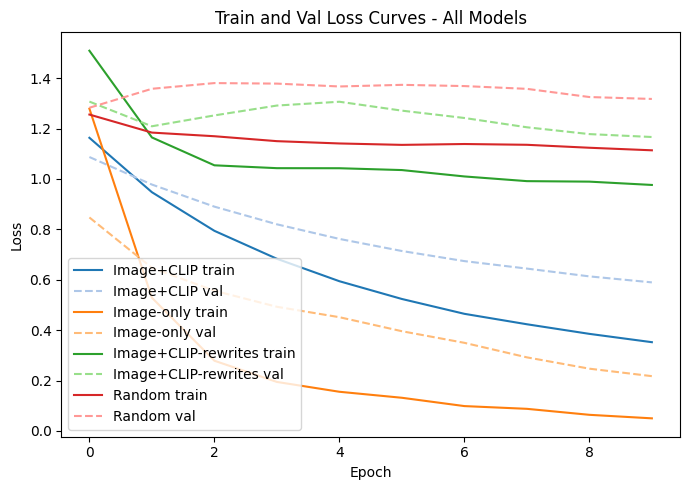

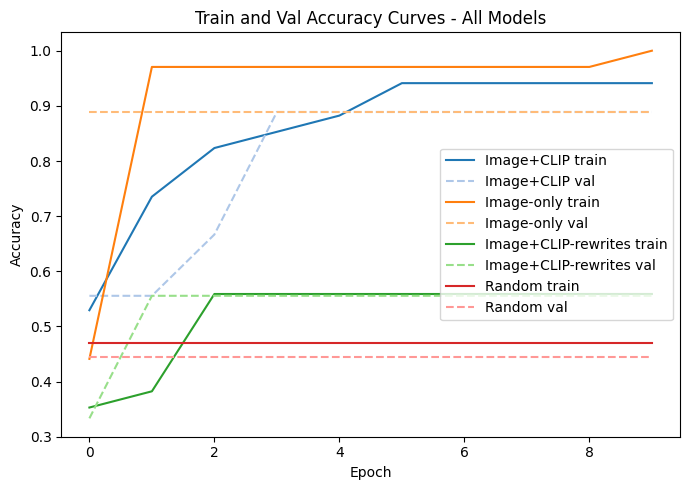

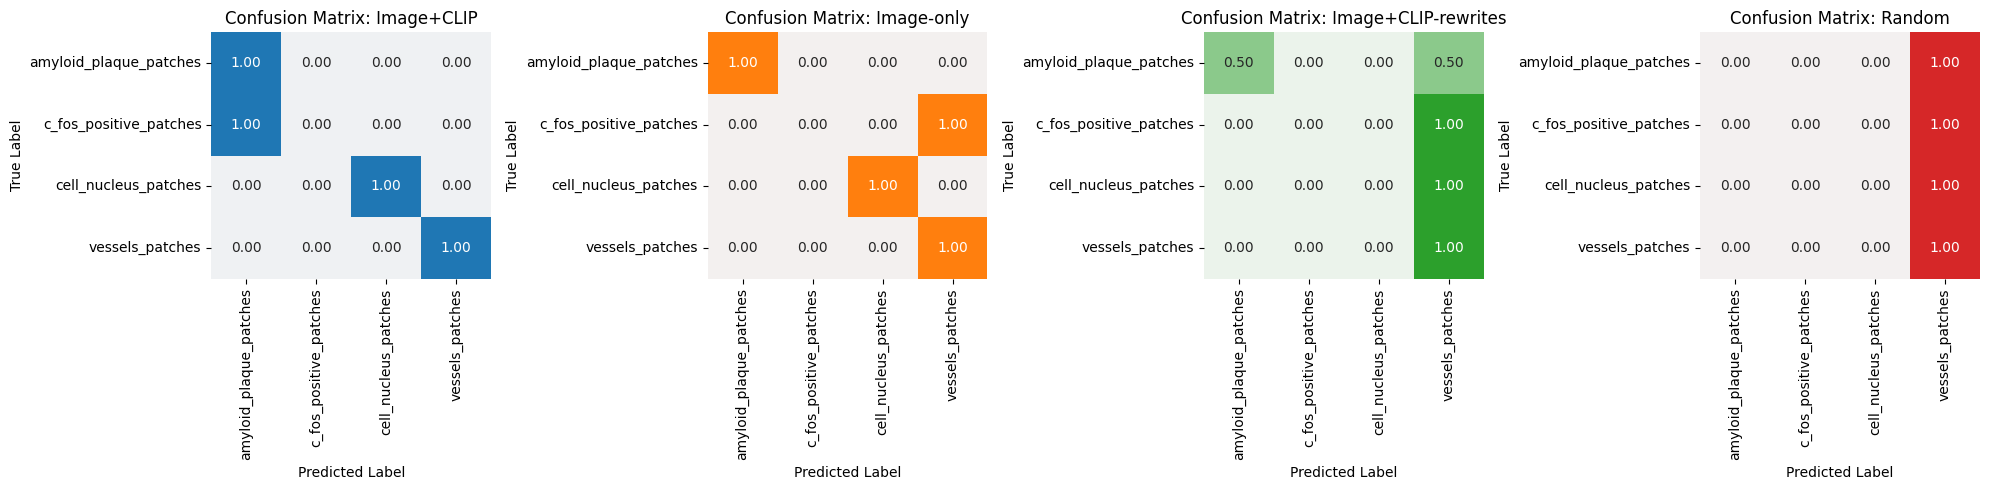

/home/ads4015/.conda/envs/monai-env1/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


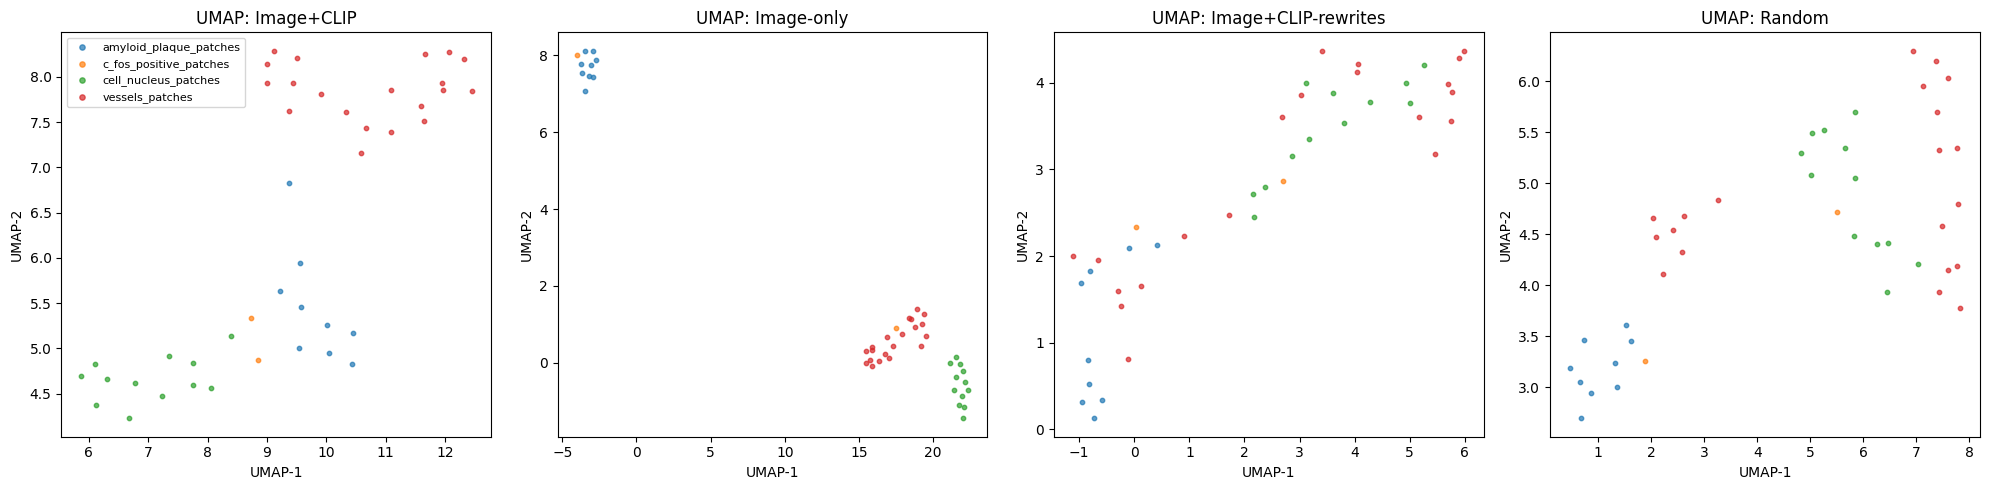


=== Summary of Final Results ===


,Model,Feature size,Embedding dim,Final Val Accuracy,Silhouette Score
0,Image+CLIP,12,512,0.888889,0.175555
1,Image-only,48,256,0.888889,0.350020
2,Image+CLIP-rewrites,12,128,0.555556,-0.159277
3,Random,12,512,0.444444,0.068999


In [18]:
if __name__ == '__main__':
    main(
        data_root=data_root,
        model_specs=model_specs,
        model_colors=model_colors,
        num_epochs=10,
        fraction=0.5
    )
    

Loading data...
amyloid_plaque_patches: kept 9/9 images (50.0%)
c_fos_positive_patches: kept 2/2 images (50.0%)
cell_nucleus_patches: kept 12/12 images (50.0%)
vessels_patches: kept 20/20 images (50.0%)

Loaded 43 total patches across 4 classes (50.0% per class).

=== Image+CLIP ===


/home/ads4015/.conda/envs/monai-env1/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


Loaded 126/159 keys from all_datasets_clip_pretrained-epochepoch=715-valval_loss=0.0222-stepstep=41528.ckpt (feature size=12)



=== Image-only ===
Loaded 126/159 keys from all_datasets_pretrained_no_clip-epochepoch=181-valval_loss=0.0241-stepstep=10556.ckpt (feature size=48)



=== Image+CLIP-rewrites ===
Loaded 126/159 keys from all_datasets_clip_pretrained-rewrites-epochepoch=042-valval_loss=0.4118-stepstep=2494.ckpt (feature size=12)



=== Random ===
Initializing random SwinUNETR (feature size=12)



--- Linear Probing: Image+CLIP ---
Image+CLIP | Epoch 01/5 | Train loss: 1.3940 | Val loss: 1.3154 | Train acc: 0.147 | Val acc: 0.444
Image+CLIP | Epoch 02/5 | Train loss: 1.1631 | Val loss: 1.1900 | Train acc: 0.559 | Val acc: 0.556
Image+CLIP | Epoch 03/5 | Train loss: 0.9793 | Val loss: 1.0937 | Train acc: 0.735 | Val acc: 0.667
Image+CLIP | Epoch 04/5 | Train loss: 0.8504 | Val loss: 1.0209 | Train acc: 0.794 | Val acc: 0.667
Image+CLIP | Epoch 05/5 | Train loss: 0.7408 | Val loss: 0.9708 | Train acc: 0.912 | Val acc: 0.667

--- Linear Probing: Image-only ---
Image-only | Epoch 01/5 | Train loss: 0.9656 | Val loss: 0.7296 | Train acc: 0.735 | Val acc: 0.889
Image-only | Epoch 02/5 | Train loss: 0.4024 | Val loss: 0.6188 | Train acc: 0.971 | Val acc: 0.889
Image-only | Epoch 03/5 | Train loss: 0.2419 | Val loss: 0.5694 | Train acc: 0.971 | Val acc: 0.889
Image-only | Epoch 04/5 | Train loss: 0.1762 | Val loss: 0.5344 | Train acc: 0.971 | Val acc: 0.889
Image-only | Epoch 05/5 | Tr

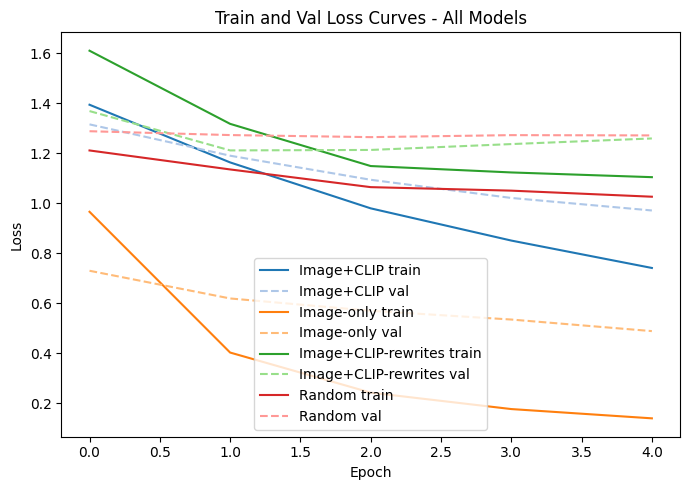

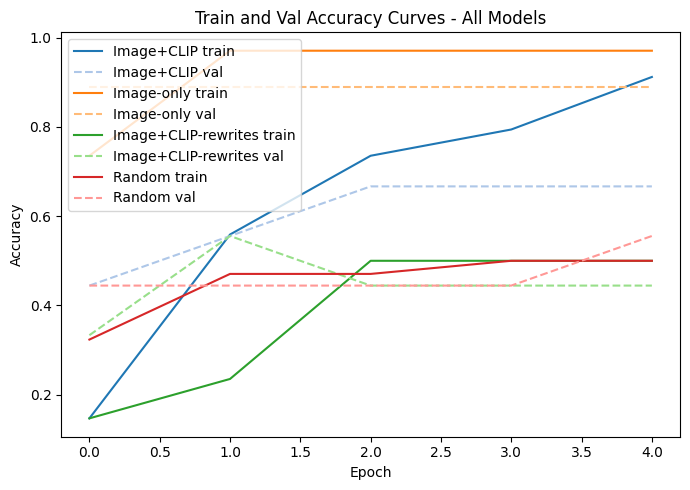

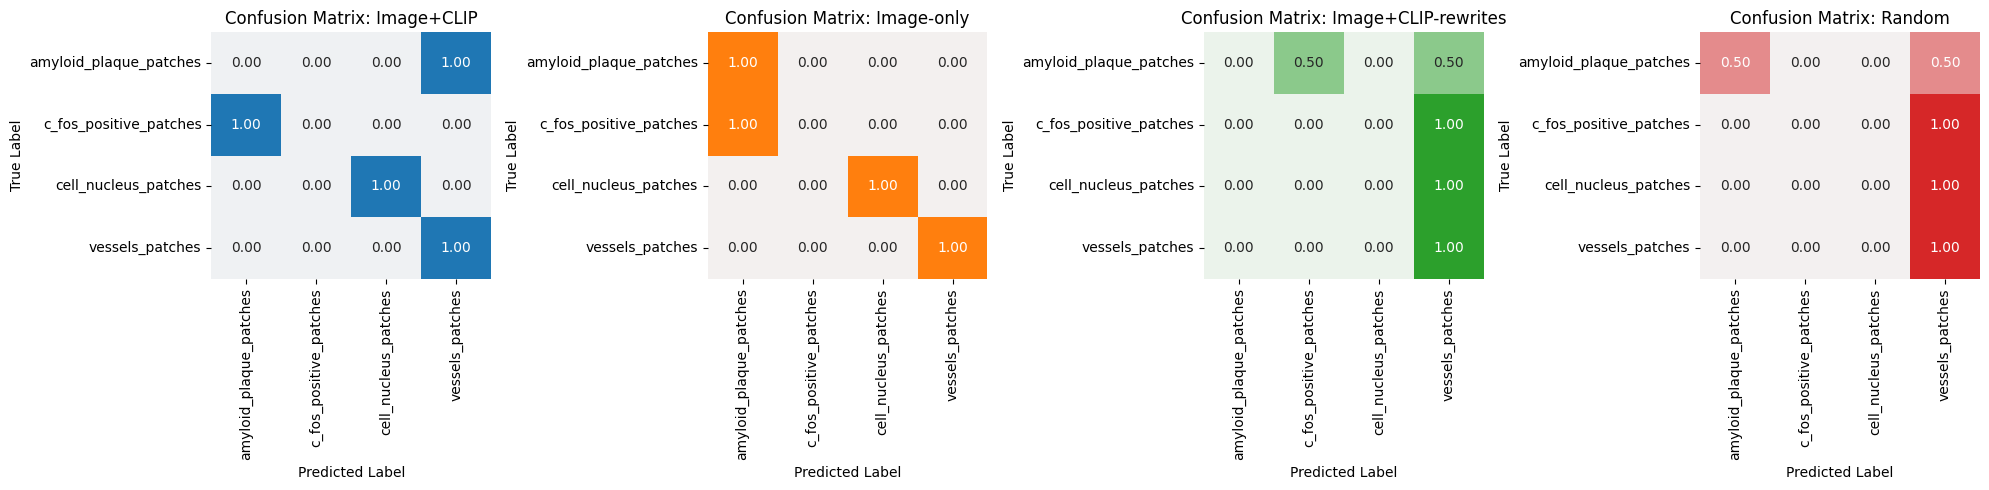

/home/ads4015/.conda/envs/monai-env1/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


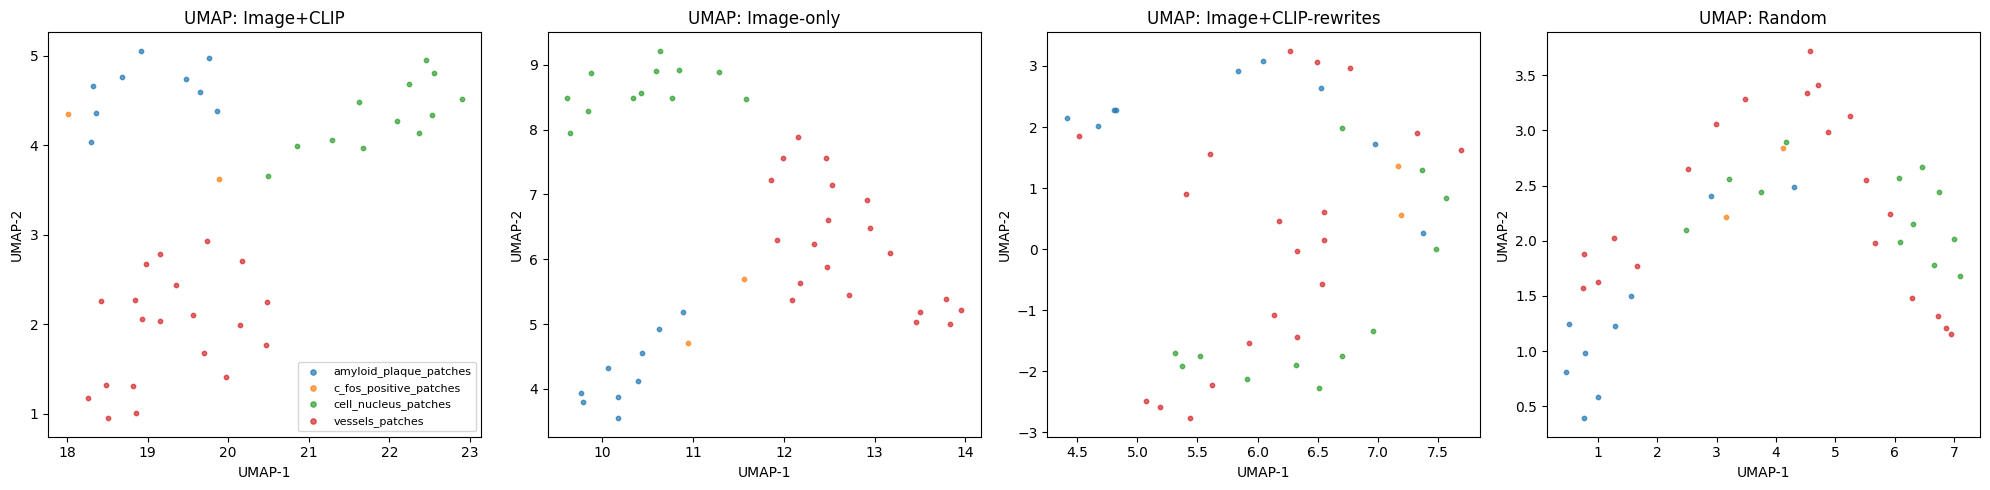


=== Summary of Final Results ===


,Model,Feature size,Embedding dim,Final Val Accuracy,Silhouette Score
1,Image-only,48,256,0.888889,0.317688
0,Image+CLIP,12,512,0.666667,0.236444
3,Random,12,512,0.555556,-0.167815
2,Image+CLIP-rewrites,12,128,0.444444,-0.388365


In [19]:
if __name__ == '__main__':
    main(
        data_root=data_root,
        model_specs=model_specs,
        model_colors=model_colors,
        num_epochs=5,
        fraction=0.5
    )
    

Loading data...
amyloid_plaque_patches: kept 9/9 images (50.0%)
c_fos_positive_patches: kept 2/2 images (50.0%)
cell_nucleus_patches: kept 12/12 images (50.0%)
vessels_patches: kept 20/20 images (50.0%)

Loaded 43 total patches across 4 classes (50.0% per class).

=== Image+CLIP ===


/home/ads4015/.conda/envs/monai-env1/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


Loaded 126/159 keys from all_datasets_clip_pretrained-epochepoch=715-valval_loss=0.0222-stepstep=41528.ckpt (feature size=12)



=== Image-only ===
Loaded 126/159 keys from all_datasets_pretrained_no_clip-epochepoch=181-valval_loss=0.0241-stepstep=10556.ckpt (feature size=48)



=== Image+CLIP-rewrites ===
Loaded 126/159 keys from all_datasets_clip_pretrained-rewrites-epochepoch=042-valval_loss=0.4118-stepstep=2494.ckpt (feature size=12)



=== Random ===
Initializing random SwinUNETR (feature size=12)



--- Linear Probing: Image+CLIP ---
Image+CLIP | Epoch 01/1 | Train loss: 1.3846 | Val loss: 1.3308 | Train acc: 0.235 | Val acc: 0.333

--- Linear Probing: Image-only ---
Image-only | Epoch 01/1 | Train loss: 0.9653 | Val loss: 0.8081 | Train acc: 0.706 | Val acc: 0.778

--- Linear Probing: Image+CLIP-rewrites ---
Image+CLIP-rewrites | Epoch 01/1 | Train loss: 1.2134 | Val loss: 1.2566 | Train acc: 0.353 | Val acc: 0.444

--- Linear Probing: Random ---
Random | Epoch 01/1 | Train loss: 1.6924 | Val loss: 1.3561 | Train acc: 0.088 | Val acc: 0.444


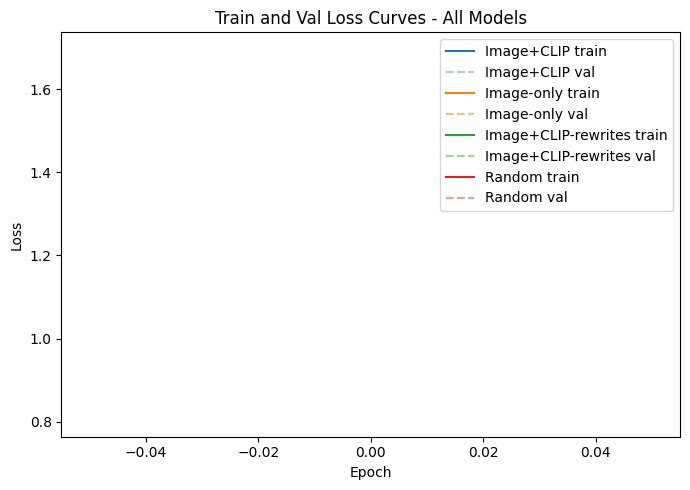

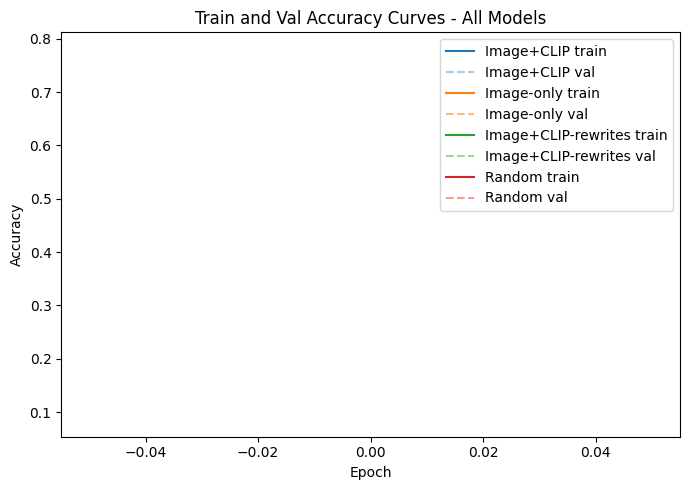

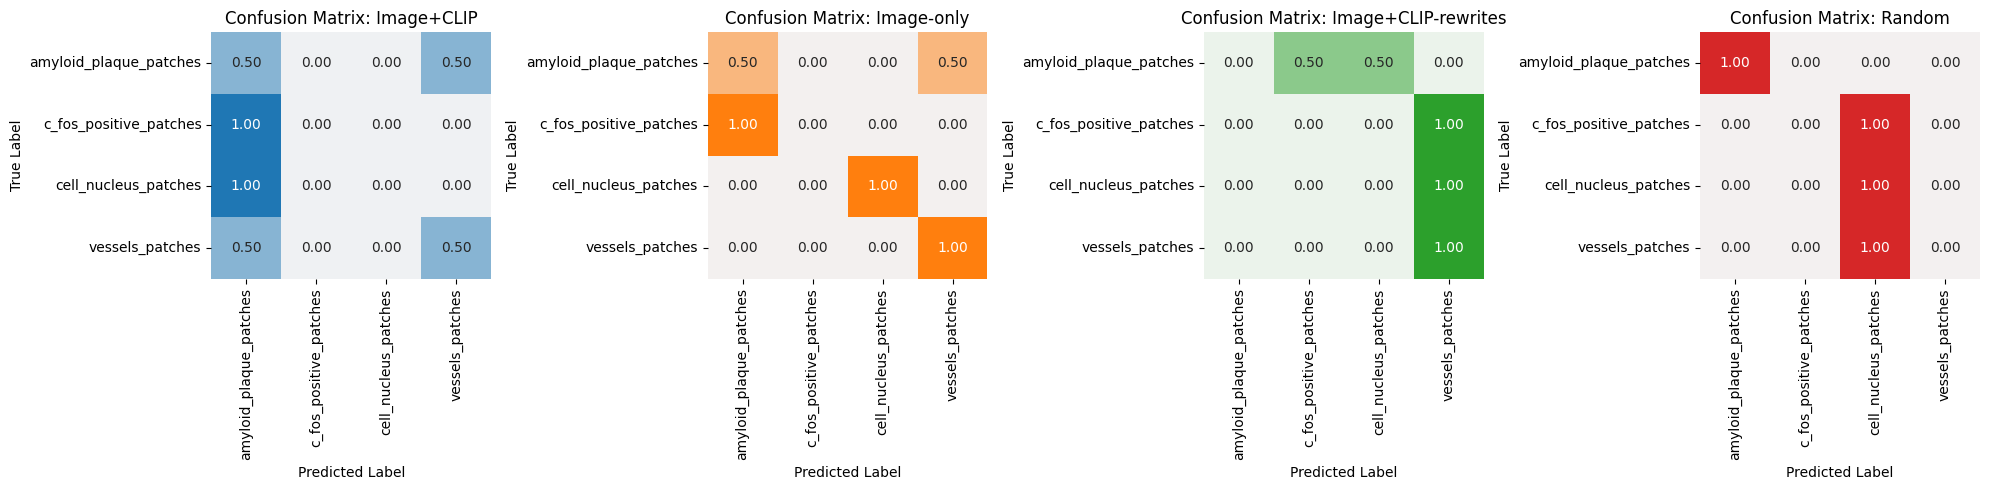

/home/ads4015/.conda/envs/monai-env1/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


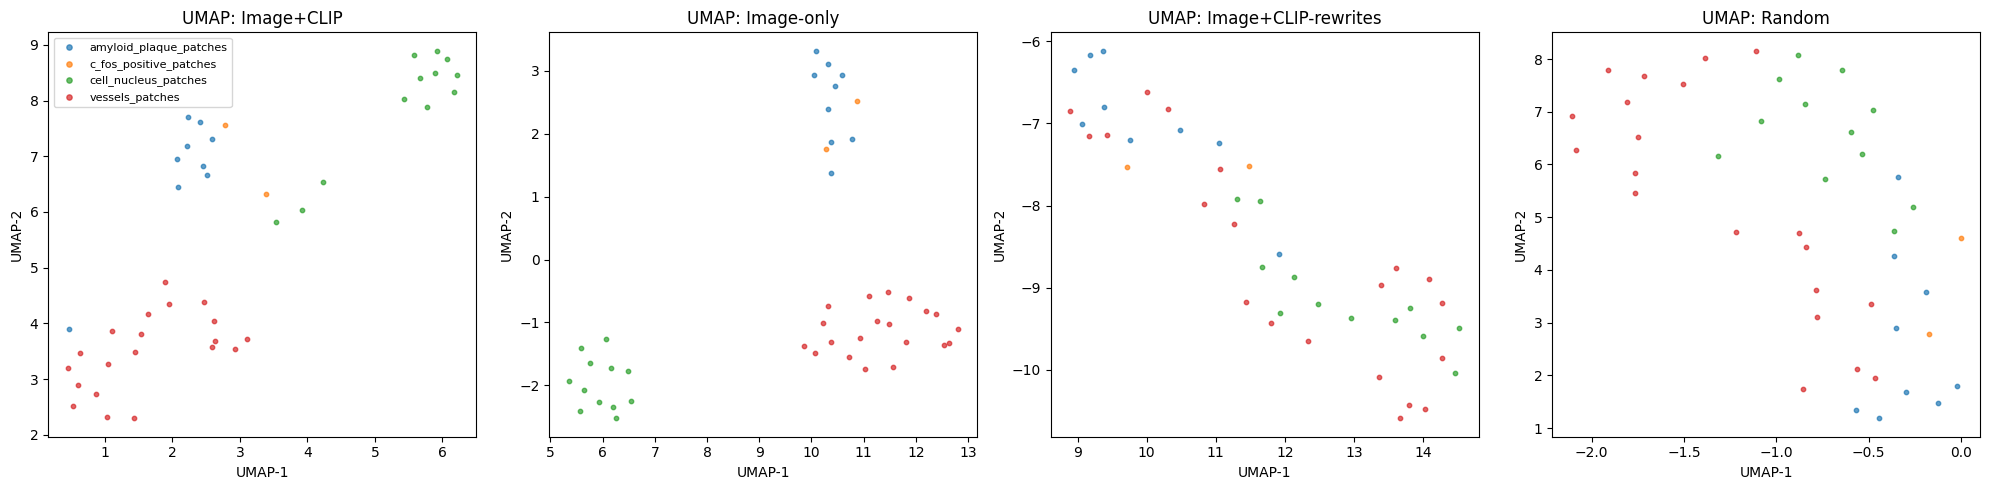


=== Summary of Final Results ===


,Model,Feature size,Embedding dim,Final Val Accuracy,Silhouette Score
1,Image-only,48,256,0.777778,0.339034
2,Image+CLIP-rewrites,12,128,0.444444,-0.238265
3,Random,12,512,0.444444,-0.110502
0,Image+CLIP,12,512,0.333333,0.257702


In [20]:
if __name__ == '__main__':
    main(
        data_root=data_root,
        model_specs=model_specs,
        model_colors=model_colors,
        num_epochs=1,
        fraction=0.5
    )
    